In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
import os
from tqdm import tqdm

from Qommunity.samplers.hierarchical.advantage_sampler import AdvantageSampler
from Qommunity.samplers.regular.leiden_sampler import LeidenSampler
from Qommunity.samplers.regular.louvain_sampler import LouvainSampler

from Qommunity.iterative_searcher.iterative_searcher import IterativeSearcher

type_net = 'Power-law' #'DSF' #'BA' # 'ER' #
NUM_NETWORKS = 1
MIN_NODES = 10
MAX_NODES = 100
num_nodes = np.linspace(MIN_NODES, MAX_NODES, MAX_NODES//MIN_NODES)
resolution = 1
num_runs = 100
os.makedirs(f"./{type_net}/resolution-{resolution}", exist_ok=True)

# Network generation

In [98]:
# Properties of the networks
if type_net=='ER':
    p = 0.4 # Probability of edge creation
elif type_net=='BA':
    m = 0.4 # Fraction of nodes
elif type_net=='Power-law':
    m, p = 1, .1
elif type_net=='DSF':
    alpha, beta, gamma, delta_in, delta_out = 0.41, 0.54, 0.05, 0.2, 0.0
else:
    raise ValueError("Network not implemented")

# Generation of the networks
if type_net=='ER':
    try:
        Graphs = np.load(f"./{type_net}/resolution-{resolution}/graphs-{NUM_NETWORKS}_p-{p}.npy", allow_pickle=True)
    except:
        Graphs = np.empty(shape=(len(num_nodes),), dtype=object)
        for i, n in enumerate(num_nodes):
            Graphs[i] = [nx.erdos_renyi_graph(n=int(n), p=p) for _ in range(NUM_NETWORKS)]
        np.save(f"./{type_net}/resolution-{resolution}/graphs-{NUM_NETWORKS}_p-{p}.npy", Graphs)        

elif type_net=='BA':
    try:
        Graphs = np.load(f"./{type_net}/resolution-{resolution}/graphs-{NUM_NETWORKS}_m-{m}.npy", allow_pickle=True)
    except:
        Graphs = np.empty(shape=(len(num_nodes),), dtype=object)
        for i, n in enumerate(num_nodes):
            Graphs[i] = [nx.barabasi_albert_graph(n=n, m=int(n*m)) for _ in range(NUM_NETWORKS)]
        np.save(f"./{type_net}/graphs-{NUM_NETWORKS}_m-{m}.npy", Graphs)

elif type_net=='Power-law':
    try:
        Graphs = np.load(f"./{type_net}/resolution-{resolution}/graphs-{NUM_NETWORKS}_m-{m}_p-{p}.npy", allow_pickle=True)
    except:
        Graphs = np.empty(shape=(len(num_nodes),), dtype=object)
        for i, n in enumerate(num_nodes):
            Graphs[i] = [nx.powerlaw_cluster_graph(n=n, m=m, p=p) for _ in range(NUM_NETWORKS)]
        np.save(f"./{type_net}/resolution-{resolution}/graphs-{NUM_NETWORKS}_m-{m}_p-{p}.npy", Graphs)

elif type_net=='DSF':
    try:
        Graphs = np.load(f"./{type_net}/resolution-{resolution}/graphs-{NUM_NETWORKS}_alpha-{alpha}_beta-{beta}_gamma-{gamma}_deltain-{delta_in}_deltaout-{delta_out}.npy", allow_pickle=True)
    except:
        Graphs = np.empty(shape=(len(num_nodes),), dtype=object)
        for i, n in enumerate(num_nodes):
            Graphs[i] = [nx.scale_free_graph(n=n, alpha=0.41, beta=0.54, gamma=0.05, delta_in=0.2, delta_out=0) for _ in range(NUM_NETWORKS)]
        np.save(f"./{type_net}/resolution-{resolution}/graphs-{NUM_NETWORKS}_alpha-{alpha}_beta-{beta}_gamma-{gamma}_deltain-{delta_in}_deltaout-{delta_out}.npy", Graphs)

else:
    raise ValueError("Network not implemented")

# Community structure

In [99]:
### ADVANTAGE ANNEALING ###
adv_modularities = np.zeros((num_nodes.shape[0], NUM_NETWORKS))
adv_communities = np.empty((num_nodes.shape[0], NUM_NETWORKS), dtype=object)
adv_times_elapsed = np.zeros((num_nodes.shape[0], NUM_NETWORKS))
num_runs_adv = 20

for i, G_nodes in enumerate(num_nodes):
    try:
        adv_modularities[i] = np.load(f"./{type_net}/resolution-{resolution}/solver-adv_runs-{num_runs_adv}_nodes-{G_nodes}_modularities.npy")
        adv_communities[i] = np.load(f"./{type_net}/resolution-{resolution}/solver-adv_runs-{num_runs_adv}_nodes-{G_nodes}_communities.npy", allow_pickle=True)
        adv_times_elapsed[i] = np.load(f"./{type_net}/resolution-{resolution}/solver-adv_runs-{num_runs_adv}_nodes-{G_nodes}_times.npy")
        print(f"Reasults loaded for n={G_nodes}")
    except:
        if G_nodes==100.0:
            for j, G in enumerate(tqdm(Graphs[i], desc=f"Networks with {G_nodes} nodes completed:")):
                adv_sampler = AdvantageSampler(G, resolution=resolution, num_reads=100, use_clique_embedding=True)
                adv_iterative= IterativeSearcher(adv_sampler)
                cs_all, mod_all, ts_all = adv_iterative.run(num_runs=num_runs_adv, save_results=False)
    
                # Only the community with the highest modularity
                adv_communities[i,j] = cs_all[mod_all.argmax()]
                adv_modularities[i,j] = mod_all.max()
                adv_times_elapsed[i,j] = ts_all[mod_all.argmax()]
                
            np.save(f"./{type_net}/resolution-{resolution}/solver-adv_runs-{num_runs_adv}_nodes-{G_nodes}_modularities.npy", adv_modularities[i])
            np.save(f"./{type_net}/resolution-{resolution}/solver-adv_runs-{num_runs_adv}_nodes-{G_nodes}_communities.npy", adv_communities[i], allow_pickle=True)
            np.save(f"./{type_net}/resolution-{resolution}/solver-adv_runs-{num_runs_adv}_nodes-{G_nodes}_times.npy", adv_times_elapsed[i])
            break

Reasults loaded for n=10.0
Reasults loaded for n=20.0
Reasults loaded for n=30.0
Reasults loaded for n=40.0
Reasults loaded for n=50.0
Reasults loaded for n=60.0
Reasults loaded for n=70.0
Reasults loaded for n=80.0
Reasults loaded for n=90.0
Reasults loaded for n=100.0


In [100]:
### LOUVAIN ###
try:
    louv_modularities = np.load(f"./{type_net}/resolution-{resolution}/solver-louv_runs-{num_runs}_modularities.npy")
    louv_communities = np.load(f"./{type_net}/resolution-{resolution}/solver-louv_runs-{num_runs}_communities.npy", allow_pickle=True)
    louv_times_elapsed = np.load(f"./{type_net}/resolution-{resolution}/solver-louv_runs-{num_runs}_times.npy")
    print("Reasults loaded")
except:
    louv_modularities = np.zeros((num_nodes.shape[0], NUM_NETWORKS))
    louv_communities = np.empty((num_nodes.shape[0], NUM_NETWORKS), dtype=object)
    louv_times_elapsed = np.zeros((num_nodes.shape[0], NUM_NETWORKS))

    for i, G_nodes in enumerate(num_nodes):
        for j, G in enumerate(tqdm(Graphs[i], desc=f"Networks with {G_nodes} nodes completed:")):
            louv_sampler = LouvainSampler(G, resolution=resolution)
            louv_iterative= IterativeSearcher(louv_sampler)
            cs_all, mod_all, ts_all = louv_iterative.run(num_runs=num_runs, save_results=False)

            # Only the community with the highest modularity
            louv_communities[i,j] = cs_all[mod_all.argmax()]
            louv_modularities[i,j] = mod_all.max()
            louv_times_elapsed[i,j] = ts_all[mod_all.argmax()]

    np.save(f"./{type_net}/resolution-{resolution}/solver-louv_runs-{num_runs}_modularities.npy", louv_modularities)
    np.save(f"./{type_net}/resolution-{resolution}/solver-louv_runs-{num_runs}_communities.npy", louv_communities, allow_pickle=True)
    np.save(f"./{type_net}/resolution-{resolution}/solver-louv_runs-{num_runs}_times.npy", louv_times_elapsed)

Networks with 100.0 nodes completed:: 100%|██████████| 1/1 [00:00<00:00, 33.57it/s]


In [101]:
### LEIDEN ###
try:
    leid_modularities = np.load(f"./{type_net}/resolution-{resolution}/solver-leid_runs-{num_runs}_modularities.npy")
    leid_communities = np.load(f"./{type_net}/resolution-{resolution}/solver-leid_runs-{num_runs}_communities.npy", allow_pickle=True)
    leid_times_elapsed = np.load(f"./{type_net}/resolution-{resolution}/solver-leid_runs-{num_runs}_times.npy")
    print("Reasults loaded")
except:
    leid_modularities = np.zeros((num_nodes.shape[0], NUM_NETWORKS))
    leid_communities = np.empty((num_nodes.shape[0], NUM_NETWORKS), dtype=object)
    leid_times_elapsed = np.zeros((num_nodes.shape[0], NUM_NETWORKS))

    for i, G_nodes in enumerate(num_nodes):
        for j, G in enumerate(tqdm(Graphs[i], desc=f"Networks with {G_nodes} nodes completed:")):
            leid_sampler = LeidenSampler(G, resolution=resolution)
            leid_iterative= IterativeSearcher(leid_sampler)
            cs_all, mod_all, ts_all = leid_iterative.run(num_runs=num_runs, save_results=False)

            # Only the community with the highest modularity
            leid_communities[i,j] = cs_all[mod_all.argmax()]
            leid_modularities[i,j] = mod_all.max()
            leid_times_elapsed[i,j] = ts_all[mod_all.argmax()]

    np.save(f"./{type_net}/resolution-{resolution}/solver-leid_runs-{num_runs}_modularities.npy", leid_modularities)
    np.save(f"./{type_net}/resolution-{resolution}/solver-leid_runs-{num_runs}_communities.npy", leid_communities, allow_pickle=True)
    np.save(f"./{type_net}/resolution-{resolution}/solver-leid_runs-{num_runs}_times.npy", leid_times_elapsed)

Networks with 100.0 nodes completed:: 100%|██████████| 1/1 [00:00<00:00, 44.54it/s]


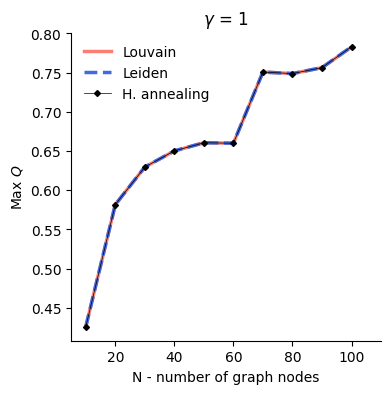

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(num_nodes,louv_modularities,"-",label="Louvain",linewidth=2.5,color="salmon",)
ax.plot(num_nodes, leid_modularities, "--", label="Leiden", linewidth=2.5, color="royalblue",)
ax.plot(num_nodes, adv_modularities, "-D", label="H. annealing", linewidth=0.5, color="black", markersize=3)

ax.legend(frameon=False)
ax.spines[["top", "right"]].set_visible(False)
ax.set_title(r'$\gamma$'+f" = {resolution}")
ax.set_xlabel("N - number of graph nodes")
ax.set_ylabel("Max "+r'$Q$')
ax.set_xlim([-5 + num_nodes[0], num_nodes[-1] + 10])

plt.savefig(f"./{type_net}/resolution-{resolution}/modularities.svg", format='svg', dpi=300)

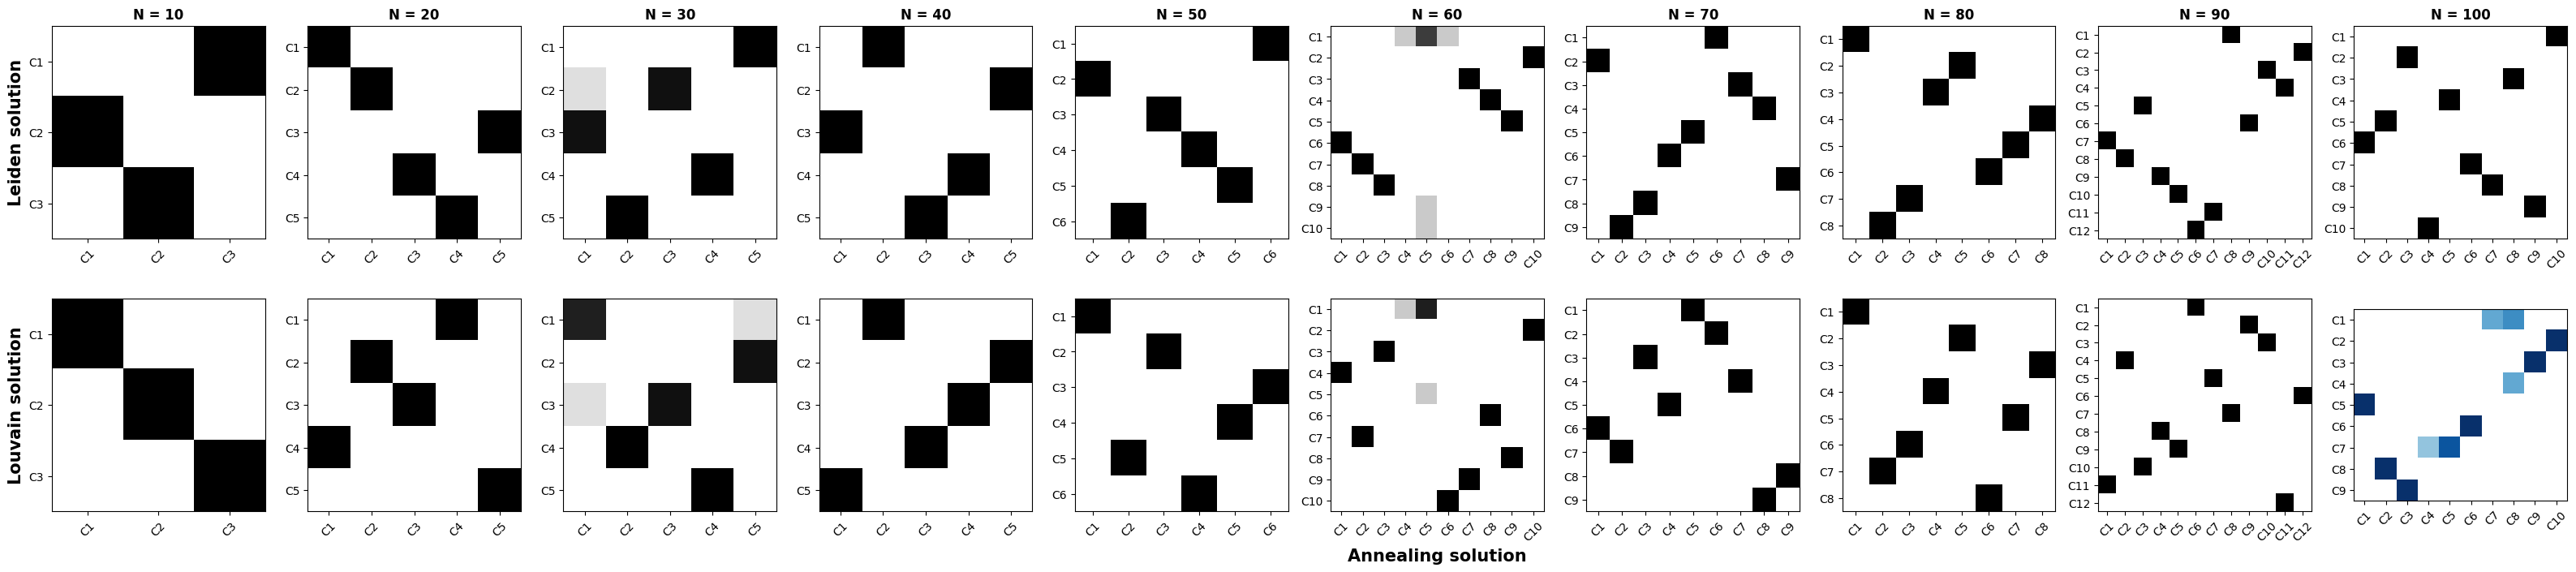

In [103]:
# Overlap between advantage and leiden solutions
if type_net=='DSF':
    num_nodes=num_nodes[:-3] # TODO: delete

dice_leid_adv = np.empty(shape=(len(num_nodes), ), dtype=object)
for i, _ in enumerate(num_nodes):
    dice_leid_adv[i] = np.zeros((len(leid_communities[i][0]), len(adv_communities[i][0])))
    for ii, c_leid in enumerate(leid_communities[i][0]):
        for jj, c_adv in enumerate(adv_communities[i][0]):
            # Dice score
            intersection = set(c_leid).intersection(set(c_adv))
            dice = 2*len(intersection) / (len(set(c_leid))+len(set(c_adv)))
            dice_leid_adv[i][ii,jj] = np.where(dice==0, np.nan, dice)

# Overlap between advantage and leiden solutions
dice_louv_adv = np.empty(shape=(len(num_nodes), ), dtype=object)
for i, _ in enumerate(num_nodes):
    dice_louv_adv[i] = np.zeros((len(louv_communities[i][0]), len(adv_communities[i][0])))
    for ii, c_louv in enumerate(louv_communities[i][0]):
        for jj, c_adv in enumerate(adv_communities[i][0]):
            # Dice score
            intersection = set(c_louv).intersection(set(c_adv))
            dice = 2*len(intersection) / (len(set(c_louv))+len(set(c_adv)))
            dice_louv_adv[i][ii,jj] = np.where(dice==0, np.nan, dice)
            
fig, ax = plt.subplots(2, len(num_nodes), figsize=(4*len(num_nodes), 8))
for i, nodes in enumerate(num_nodes):
    # Louvain vs Advantage
    if adv_modularities[i]>leid_modularities[i]:
        color = "Blues"
    elif adv_modularities[i]==leid_modularities[i]:
        color = "binary"
    else:
        color="Reds"
    ax[0,i].imshow(dice_leid_adv[i], cmap=color, vmin=0, vmax=1)

    # Louvain vs Advantage
    if adv_modularities[i]>louv_modularities[i]:
        color = "Blues"
    elif adv_modularities[i]==louv_modularities[i]:
        color = "binary"
    else:
        color="Reds"
    ax[1,i].imshow(dice_louv_adv[i], cmap=color, vmin=0, vmax=1)

    ax[0,i].set_title(f"N = {int(nodes)}", fontweight="bold")

    # Leiden
    ax[0,i].set_yticks(list(range(len(leid_communities[i][0]))))
    ax[0,i].set_yticklabels([f"C{k}" for k in range(1,len(leid_communities[i][0])+1)])

    # Louvain
    ax[1,i].set_yticks(list(range(len(louv_communities[i][0]))))
    ax[1,i].set_yticklabels([f"C{k}" for k in range(1,len(louv_communities[i][0])+1)])

    # Advantage
    ax[0,i].set_xticks(list(range(len(adv_communities[i][0]))))
    ax[0,i].set_xticklabels([f"C{k}" for k in range(1,len(adv_communities[i][0])+1)], rotation=45)
    ax[1,i].set_xticks(list(range(len(adv_communities[i][0]))))
    ax[1,i].set_xticklabels([f"C{k}" for k in range(1,len(adv_communities[i][0])+1)], rotation=45)

ax[0,0].set_ylabel("Leiden solution", fontweight="bold", fontsize=15)
ax[1,0].set_ylabel("Louvain solution", fontweight="bold", fontsize=15)
ax[1,len(num_nodes)//2].set_xlabel("Annealing solution", fontweight="bold", fontsize=15)

plt.savefig(f"./{type_net}/resolution-{resolution}/communities.svg", format='svg', dpi=300)

In [104]:
if type_net=='DSF':
    import netgraph
    def plot_network_in_communities(graph, comms, filename=None, community_to_color=None, hub_size=False, node_labels=False, ax=None):
      # Determine node size based on eigenvector centrality
      if hub_size==False:
        eigen_centrality = 5
      else:
        eigen_centrality = {node: hub_size*eigen for node, eigen in nx.eigenvector_centrality(graph).items()}
      directed = nx.is_directed(graph)
    
      # Organize nodes and colors
      node_to_community = dict()
      for community_id, c in enumerate(comms):
          for node in c:
              node_to_community[node] = community_id
      if community_to_color==None:
        community_to_color = np.random.rand(community_id+1,3)
      node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}
      
      # Plotting
      netgraph.Graph(graph,
            node_color=node_color, edge_alpha=.5,
            node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
            edge_color="black", node_edge_width=0.1, node_size=eigen_centrality, edge_layout='bundled', edge_layout_kwargs=dict(k=2000),
            edge_width=.75 if directed else 0.25, node_labels=node_labels, node_label_fontdict={"size": 10}, 
            arrows=True if directed else False, ax=ax
      )
      if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        print("\nYour plot is saved to {}".format(filename))
    comm_colors = [
        [1,1,0],
        [0,1,0.5],
        [0.5,.5,0.5],
        [0.5,.8,0.75],
        [0.7,.2,0.8],
        [0.1,0.8,0.1],
        [0,1,1],
    ]

    fig, ax = plt.subplots(1,2,figsize=(14,8))
    id = -5
    plot_network_in_communities(Graphs[id][0], adv_communities[id][0], community_to_color=comm_colors, ax=ax[0], node_labels=True)
    plot_network_in_communities(Graphs[id][0], louv_communities[id][0], community_to_color=comm_colors, ax=ax[1], node_labels=True)
        
    ax[0].set_xlabel(f"Annealing solution Q={round(adv_modularities[id][0],4)}", fontweight='bold', fontsize=15)
    ax[1].set_xlabel(f"Louvain solution Q={round(louv_modularities[id][0],4)}", fontweight='bold', fontsize=15)
    fig.suptitle("N=60", fontweight='bold', fontsize=18)

    fig.savefig(f"./{type_net}/resolution-{resolution}/communities_DSF.svg", format='svg', dpi=300)